## Imports

In [1]:
import pandas as pd
import os
import requests
import urllib.parse
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from mtcnn.mtcnn import MTCNN
from io import BytesIO
import hashlib




# Load data

In [2]:
from mtcnn import MTCNN

# Instantiate the MTCNN detector
detector = MTCNN()

def download_image(url, dirname="images"):
    filename = os.path.join(dirname, hashlib.md5(url.encode()).hexdigest() + ".jpg")
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    return filename

def process_image(filename):
    try:
        image = Image.open(filename)
    except IOError:
        print(f"Cannot open {filename}. It might not be a valid image file.")
        return None
    image = image.convert('RGB')
    pixels = np.asarray(image)

    # Detect faces in the image
    results = detector.detect_faces(pixels)
    
    # Skip images if no face is detected
    if len(results) == 0:
        print(f"No face detected in {filename}")
        return None

    # Extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height

    # Extract the face
    face = pixels[y1:y2, x1:x2]

    # Resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize((64, 64))
    return np.array(image)


# Read your dataframe
df = pd.read_excel("output.xlsx")


# Create a directory to store the images

In [3]:
if not os.path.exists("images"):
    os.makedirs("images")

# Download and process images
df['image'] = df['image_link'].apply(lambda url: process_image(download_image(url)))

1/1 [==============================] - 0s 68ms/step
No face detected in images\ee92ed983307cbe6ee8f9fda277f5af2.jpg
1/1 [==============================] - 0s 73ms/step
Cannot open images\2a70fedbf5dbdfebbb910b8c1022a385.jpg. It might not be a valid image file.
1/1 [==============================] - 0s 129ms/step


In [ ]:
# Drop rows where no face was detected (image is None)
df = df[df['image'].notna()]

In [ ]:
print(df.columns)

Index(['image_link', 'label', 'image'], dtype='object')


Download the images and process them

Prepare the data

In [ ]:
X = np.stack(df['image'])
y = df['label'].values

Split the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define data augmentation

In [8]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

Fit the data augmentation

In [9]:
datagen.fit(X_train)

Rescale test data

In [10]:
X_test = X_test / 255.0

Define the model

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

In [12]:
# v2 of Model
from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1:])),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(set(y)), activation='softmax')
])


Compile the model

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Convert labels to categorical one-hot encoding


In [14]:
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

train the model

In [22]:
model.fit(datagen.flow(X_train, y_train_encoded, batch_size=32), epochs=29, validation_data=(X_test, y_test_encoded))

Epoch 1/29
18/18 [==============================] - 63s 4s/step - loss: 0.6771 - accuracy: 0.5707 - val_loss: 0.6794 - val_accuracy: 0.5507
Epoch 2/29
18/18 [==============================] - 68s 4s/step - loss: 0.6816 - accuracy: 0.5707 - val_loss: 0.6784 - val_accuracy: 0.5507
Epoch 3/29
18/18 [==============================] - 69s 4s/step - loss: 0.6780 - accuracy: 0.5707 - val_loss: 0.6755 - val_accuracy: 0.5507
Epoch 4/29
18/18 [==============================] - 67s 4s/step - loss: 0.6769 - accuracy: 0.5707 - val_loss: 0.6750 - val_accuracy: 0.5507
Epoch 5/29
18/18 [==============================] - 69s 4s/step - loss: 0.6824 - accuracy: 0.5707 - val_loss: 0.6737 - val_accuracy: 0.5507
Epoch 6/29
18/18 [==============================] - 69s 4s/step - loss: 0.6822 - accuracy: 0.5688 - val_loss: 0.6743 - val_accuracy: 0.5507
Epoch 7/29
18/18 [==============================] - 68s 4s/step - loss: 0.6767 - accuracy: 0.5707 - val_loss: 0.6692 - val_accuracy: 0.5507
Epoch 8/29
18/18 [==

Evaluate the model

In [23]:
# 
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

5/5 [==============================] - 3s 478ms/step - loss: 0.6648 - accuracy: 0.5652
Test Loss:  0.664830207824707
Test Accuracy:  0.5652173757553101


5/5 [==============================] - 0s 23ms/step - loss: 0.7315 - accuracy: 0.6259
Test Loss:  0.7314891219139099
Test Accuracy:  0.6258992552757263

# Testresult of First walktrough with 450 pictures
4/4 [==============================] - 0s 32ms/step - loss: 0.6131 - accuracy: 0.6698
Test Loss:  0.6130647659301758
Test Accuracy:  0.6698113083839417

Test

In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load image
img_path = 'C:\\Users\\SIT\\Desktop\\project\\10097829347437201.jpg'
img = image.load_img(img_path, target_size=(64, 64))

# Display the image
plt.imshow(img)
plt.title("Test Image")
plt.show()

# Preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0  # Rescale

# Make prediction
predictions = model.predict(x)
predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])

print("The predicted class is:", predicted_class)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\SIT\\Desktop\\project\\10097829347437201.jpg'

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load image
img_path = 'C:\\Users\\SIT\\Desktop\\project\\images\\Sarai.jpg'
img = image.load_img(img_path, target_size=(64, 64))

# Display the image
plt.imshow(img)
plt.title("Test Image")
plt.show()

# Preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0  # Rescale

# Make prediction
predictions = model.predict(x)
predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])

print("The predicted class is:", predicted_class)


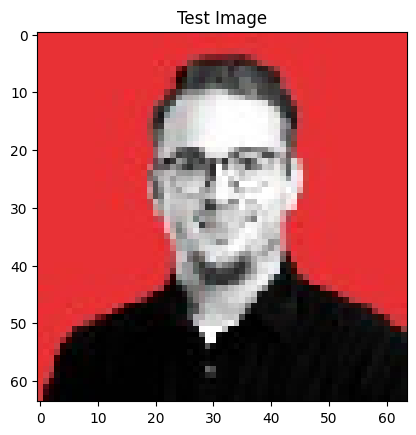

1/1 [==============================] - 0s 69ms/step
The predicted class is: [1]


In [26]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load image
img_path = 'C:\\Users\\SIT\\Desktop\\project\\images\\4a3241354b9d22aecf4d42be78895d4a.jpg'
img = image.load_img(img_path, target_size=(64, 64))

# Display the image
plt.imshow(img)
plt.title("Test Image")
plt.show()

# Preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0  # Rescale

# Make prediction
predictions = model.predict(x)
predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])

print("The predicted class is:", predicted_class)


In [27]:
model.save('models/politicalview')

INFO:tensorflow:Assets written to: models/politicalview\assets


INFO:tensorflow:Assets written to: models/politicalview\assets
